In [1]:
# Import required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the Data
data = pd.read_csv('./Resources/tickets_2024_09.csv', low_memory=False)
data

,OBJECTID,TICKET_NUMBER,VIOLATION_TYPE_DESC,ISSUE_DATE,ISSUE_TIME,ISSUING_AGENCY_CODE,ISSUING_AGENCY_NAME,ISSUING_AGENCY_SHORT,VIOLATION_CODE,VIOLATION_PROC_DESC,...,PENALTY_2,PENALTY_3,PENALTY_4,PENALTY_5,XCOORD,YCOORD,LATITUDE,LONGITUDE,MAR_ID,GIS_LAST_MOD_DTTM
0,83487425,260566401,P,2024/09/05 04:00:00+00,657,54,ST.ELZBETH HOSPITAL SECURITY GUARDS,SEH,P170,FAILURE TO DISPLAY CURRENT TAGS,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2024/10/16 14:04:18+00
1,83487426,266969312,P,2024/09/18 04:00:00+00,133,59,US. BUREAU OF ENGRAVING AND PRINTNG,BEP,P055,NO PARKING ANYTIME,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2024/10/16 14:04:18+00
2,83487445,266974724,P,2024/09/01 04:00:00+00,1020,59,US. BUREAU OF ENGRAVING AND PRINTNG,BEP,P012,DISOBEYING OFFICIAL SIGN,...,0,0,0,0,397076.780,135370.390,38.886,-77.034,810050.0,2024/10/16 14:04:18+00
3,83487446,266974735,P,2024/09/08 04:00:00+00,1051,59,US. BUREAU OF ENGRAVING AND PRINTNG,BEP,P170,FAILURE TO DISPLAY CURRENT TAGS,...,0,0,0,0,397328.708,135348.587,38.886,-77.031,805720.0,2024/10/16 14:04:18+00
4,83487447,266974746,P,2024/09/08 04:00:00+00,1108,59,US. BUREAU OF ENGRAVING AND PRINTNG,BEP,P170,FAILURE TO DISPLAY CURRENT TAGS,...,0,0,0,0,397328.637,135237.646,38.885,-77.031,801948.0,2024/10/16 14:04:18+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98488,83587778,8271938231,P,2024/09/30 04:00:00+00,1535,15,DEPARTMENT OF PUBLIC WORKS,DPW,P012,DISOBEYING OFFICIAL SIGN,...,0,0,0,0,399383.850,135200.010,38.885,-77.007,812200.0,2024/10/16 14:04:59+00
98489,83587779,8271938242,P,2024/09/30 04:00:00+00,1638,15,DEPARTMENT OF PUBLIC WORKS,DPW,P259,NO STOPPING OR STANDING IN PM RUSH HOUR ZONE,...,0,0,0,0,399995.838,135331.512,38.886,-77.000,803850.0,2024/10/16 14:04:59+00
98490,83587780,8271938253,P,2024/09/30 04:00:00+00,1639,15,DEPARTMENT OF PUBLIC WORKS,DPW,P170,FAILURE TO DISPLAY CURRENT TAGS,...,0,0,0,0,399995.838,135331.512,38.886,-77.000,803850.0,2024/10/16 14:04:59+00
98491,83587781,8271938264,P,2024/09/30 04:00:00+00,1640,15,DEPARTMENT OF PUBLIC WORKS,DPW,P259,NO STOPPING OR STANDING IN PM RUSH HOUR ZONE,...,0,0,0,0,399995.838,135331.512,38.886,-77.000,803850.0,2024/10/16 14:04:59+00


In [3]:
#  Drop Irrelevant Columns
irrelevant_columns = [
    'OBJECTID', 'TICKET_NUMBER', 'DISPOSITION_CODE', 'DISPOSITION_DESC',
    'DISPOSITION_DATE', 'PENALTY_2', 'PENALTY_3', 'PENALTY_4', 'PENALTY_5', 'GIS_LAST_MOD_DTTM'
]
data.drop(columns=irrelevant_columns, inplace=True, errors='ignore')


In [4]:
#  Filter Data for Parking-Related Violations ('VIOLATION_TYPE_DESC' == "P")
data = data[data['VIOLATION_TYPE_DESC'] == "P"]

In [5]:
#  Combine Rare `VIOLATION_CODE` Types for "P"
violation_code_counts = data['VIOLATION_CODE'].value_counts()
rare_codes = violation_code_counts[violation_code_counts < 100].index

# Using .loc to avoid the SettingWithCopyWarning
data.loc[:, 'VIOLATION_CODE'] = data['VIOLATION_CODE'].apply(lambda x: 'OTHER' if x in rare_codes else x)


In [6]:
#  Add Out-of-State Feature
# Replace 'YOUR_STATE' with the actual state code you consider as "in-state"
data = data.copy()  # Make a full copy of the data to avoid chained assignments
data['OUT_OF_STATE'] = (data['PLATE_STATE'] != 'YOUR_STATE').astype(int)


In [7]:
#  Create Binary Classification for `DISPOSITION_TYPE`
data['DISPOSITION_BINARY'] = (data['DISPOSITION_TYPE'] == 'Liable').astype(int)


In [8]:
#  Filter for Liable Tickets Only
liable_data = data[data['DISPOSITION_BINARY'] == 1].copy()

In [9]:
#  Select Features for Clustering
# We'll use 'VIOLATION_CODE', 'FINE_AMOUNT', 'ISSUING_AGENCY_NAME', 'OUT_OF_STATE'
# Encode categorical variables for clustering
label_encoder = LabelEncoder()
liable_data['VIOLATION_CODE'] = label_encoder.fit_transform(liable_data['VIOLATION_CODE'])
liable_data['ISSUING_AGENCY_NAME'] = label_encoder.fit_transform(liable_data['ISSUING_AGENCY_NAME'])


In [28]:
# Apply clustering (e.g., KMeans with 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
liable_data['Cluster'] = kmeans.fit_predict(liable_data[['VIOLATION_CODE', 'FINE_AMOUNT', 'ISSUING_AGENCY_NAME', 'OUT_OF_STATE']])


In [10]:
#  Standardize the Data
scaler = StandardScaler()
liable_data_scaled = scaler.fit_transform(liable_data[['VIOLATION_CODE', 'FINE_AMOUNT', 'ISSUING_AGENCY_NAME', 'OUT_OF_STATE']])


In [11]:
#  Clustering with K-Means
# Experiment with different numbers of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
liable_data['Cluster'] = kmeans.fit_predict(liable_data_scaled)

In [12]:
#  Analyze Clusters
# Calculate average of numeric features in each cluster and display in a more structured format
cluster_summary = liable_data.groupby('Cluster').mean(numeric_only=True)

# Optional: Round values to two decimal points for better readability
cluster_summary = cluster_summary.round(2)

# Display the summary in a nice table format
print("Cluster Summary:")
display(cluster_summary)


Cluster Summary:


,ISSUE_TIME,ISSUING_AGENCY_CODE,ISSUING_AGENCY_NAME,VIOLATION_CODE,VEHICLE_TYPE,MULTI_OWNER_NUMBER,FINE_AMOUNT,TOTAL_PAID,PENALTY_1,XCOORD,YCOORD,LATITUDE,LONGITUDE,MAR_ID,OUT_OF_STATE,DISPOSITION_BINARY
Cluster,,,,,,,,,,,,,,,,
0,1239.94,14.83,0.99,26.45,NaN,1.218727e+08,86.13,15.54,5.27,397998.15,137545.99,38.91,-77.02,775862.12,1.0,1.0
1,1315.51,14.59,0.98,8.36,NaN,1.242239e+08,49.09,12.10,0.85,398464.83,137287.00,38.90,-77.02,779265.79,1.0,1.0
2,1143.60,11.20,4.20,11.60,NaN,0.000000e+00,61.00,16.00,0.00,397627.41,139411.24,38.92,-77.03,700790.60,1.0,1.0


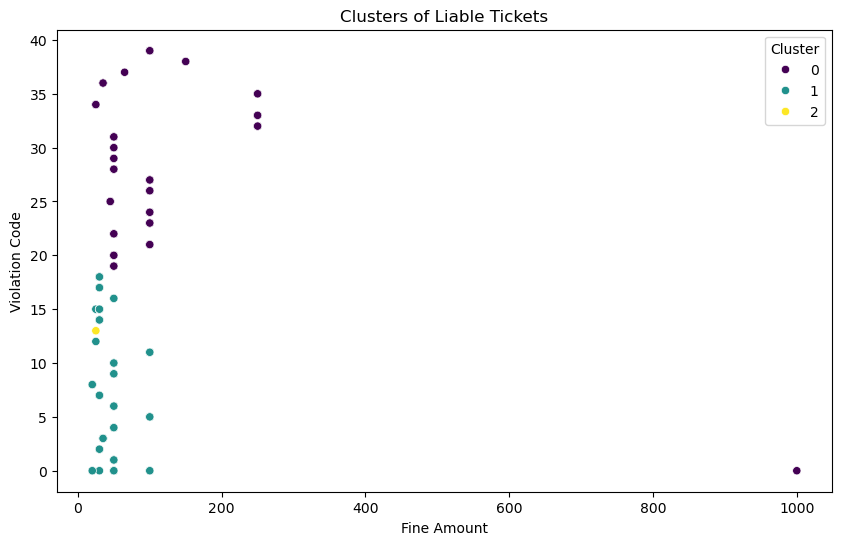

In [13]:
# Visualize the Clusters
# Visualization of clusters based on fine amount and violation code
plt.figure(figsize=(10, 6))
sns.scatterplot(x='FINE_AMOUNT', y='VIOLATION_CODE', hue='Cluster', data=liable_data, palette='viridis')
plt.title('Clusters of Liable Tickets')
plt.xlabel('Fine Amount')
plt.ylabel('Violation Code')
plt.legend(title='Cluster')
plt.show()

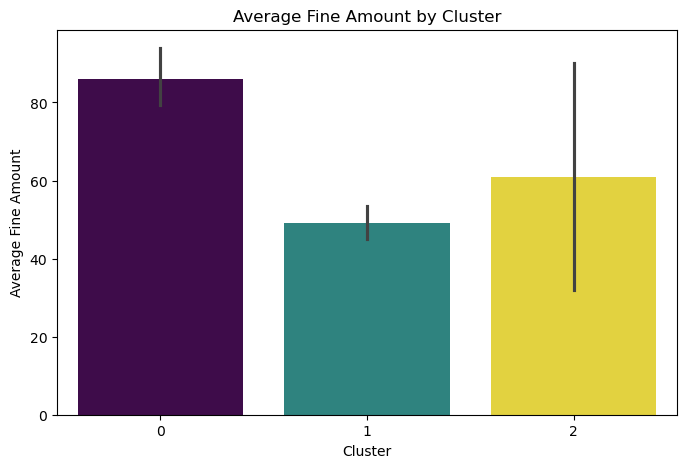

In [14]:
# Average fine amount cluster
plt.figure(figsize=(8, 5))
sns.barplot(x='Cluster', y='FINE_AMOUNT', data=liable_data, estimator='mean', palette='viridis', hue='Cluster', dodge=False)
plt.title('Average Fine Amount by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Fine Amount')
plt.legend([],[], frameon=False)  # Removes the legend since it's not needed
plt.show()


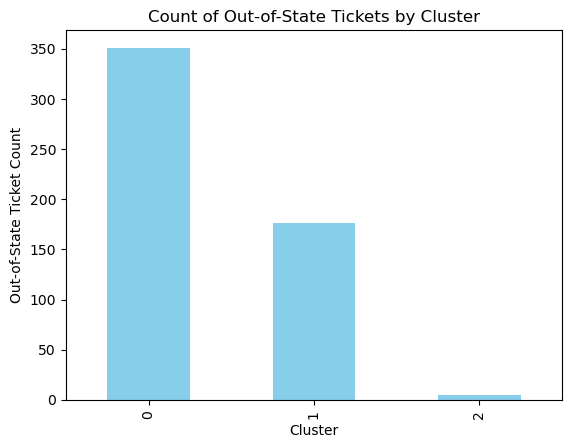

In [15]:
# Additional visualization: Count of out-of-state tickets per cluster
out_of_state_counts = liable_data.groupby('Cluster')['OUT_OF_STATE'].sum()
out_of_state_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Out-of-State Tickets by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Out-of-State Ticket Count')
plt.show()

In [17]:
# Import necessary libraries

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [18]:
# Load and preprocess your data
# Assuming 'data' is your DataFrame and you've already processed it as required

# Select features and target
# Adjust these columns based on your processed DataFrame
X = data[['VIOLATION_CODE', 'FINE_AMOUNT', 'ISSUING_AGENCY_NAME', 'OUT_OF_STATE']]
y = data['DISPOSITION_BINARY']



In [22]:
# Encode categorical features if needed
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Explicitly use .loc to avoid SettingWithCopyWarning
X.loc[:, 'VIOLATION_CODE'] = label_encoder.fit_transform(X['VIOLATION_CODE'])
X.loc[:, 'ISSUING_AGENCY_NAME'] = label_encoder.fit_transform(X['ISSUING_AGENCY_NAME'])


In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier with class weight balanced
classifier = RandomForestClassifier(random_state=42, class_weight='balanced')
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)



In [24]:
# Evaluate the model
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.6391368266302636

Confusion Matrix:
 [[12117  6828]
 [   45    56]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.64      0.78     18945
           1       0.01      0.55      0.02       101

    accuracy                           0.64     19046
   macro avg       0.50      0.60      0.40     19046
weighted avg       0.99      0.64      0.78     19046

